# **Meridian**

Notebook created by modifying the Meridian demo notebook available on 

https://colab.research.google.com/github/google/meridian/blob/main/demo/Meridian_Getting_Started.ipynb.

All text and major code and comments come from there.

<a name="install"></a>
## Step 0: Install

1\. Make sure you are using one of the available GPU Colab runtimes which is **required** to run Meridian. You can change your notebook's runtime in `Runtime > Change runtime type` in the menu. All users can use the T4 GPU runtime which is sufficient to run the demo colab, free of charge. Users who have purchased one of Colab's paid plans have access to premium GPUs (such as V100, A100 or L4 Nvidia GPU).

2\. Install the latest version of Meridian, and verify that GPU is available.

In [1]:
# Install meridian: from PyPI @ latest release
!pip install --upgrade google-meridian[colab,and-cuda]

# Install meridian: from PyPI @ specific version
# !pip install google-meridian[colab,and-cuda]==1.0.3

# Install meridian: from GitHub @HEAD
# !pip install --upgrade "google-meridian[colab,and-cuda] @ git+https://github.com/google/meridian.git"

  Using cached google_meridian-1.1.0-py3-none-any.whl.metadata (22 kB)
  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached scipy-1.15.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached tensorflow-2.18.1-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached tensorflow_probability-0.25.0-py2.py3-none-any.whl.metadata (13 kB)
  Using cached tf_keras-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached numpy-2.0.2-cp312-cp312-win_amd64.whl.metadata (59 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl.metadata (22 kB)
  Using cached nvidia_cublas_cu12-12.5.3.2-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.5.82-py3-none-win_amd64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_nvcc_cu12-12.5.82-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_nvr

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

# check if GPU is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

np.random.seed(12345)




Your runtime has 16.9 gigabytes of available RAM

Num GPUs Available:  0
Num CPUs Available:  1


<a name="load-data"></a>
## Step 1: Load the data

Load the [simulated dataset in CSV format](https://github.com/google/meridian/blob/main/meridian/data/simulated_data/csv/geo_all_channels.csv) as follows.

1\. Map the column names to their corresponding variable types. The required variable types are `time`, `controls`, `population`, `kpi`, `revenue_per_kpi`, `media` and `spend`. For the definition of each variable, see
[Collect and organize your data](https://developers.google.com/meridian/docs/user-guide/collect-data).

In [3]:
coord_to_columns = load.CoordToColumns(
    time='fake_date',
    controls=['ct[1]'],
    kpi='y_sim[1]',
    media=[
        'x[1]',
        'x[2]',
        'x[3]',
    ],
    media_spend=[
        'x[1]',
        'x[2]',
        'x[3]',
    ]
)

2\. Map the media variables and the media spends to the designated channel names intended for display in the output.

In [4]:
correct_media_to_channel = {
    'x[1]': 'Channel_1',
    'x[2]': 'Channel_2',
    'x[3]': 'Channel_3'
}
correct_media_spend_to_channel = {
    'x[1]': 'Channel_1',
    'x[2]': 'Channel_2',
    'x[3]': 'Channel_3'
}

3\. Load the data

In [5]:
df = pd.read_csv('C:/Users/usuari/Dropbox/1.Estudos/A. MASTER (MESIO)/2º Master - 2º Q/Z. TFM - Adsmurai/4. UPC Bayesian/TFM - Simulations/Sim1-OBS_Data.csv', sep=";", thousands='.')

#DATE FORMAT
df['fake_date'] = pd.to_datetime(df['fake_date'])

#NUMERIC FORMAT
exclude_cols = ['fake_date', 'Unnamed: 0']  # ajusta según tu caso
cols_to_convert = [col for col in df.columns if col not in exclude_cols]
for col in cols_to_convert:
    df[col] = df[col].astype(str).str.replace('.', '', regex=False)  # elimina separador de miles
    df[col] = df[col].str.replace(',', '.', regex=False)             # convierte coma decimal a punto
    df[col] = pd.to_numeric(df[col], errors='coerce')                # convierte a numérico

#VIEW
df.head()

Unnamed: 0      y_sim[1]         x[1]        x[2]         x[3]       ct[1]  \
0       t= 0  23660.044191   500.576555  610.464489   513.267156  637.549712   
1       t= 1  20524.954196  1083.238101  731.102682  1482.318832  449.112151   
2       t= 2  24004.581730   249.875782  102.770843   859.058663  700.124430   
3       t= 3  14487.771832  1096.554203  247.119117   572.540084  105.569535   
4       t= 4  14558.765792   598.098742  524.130959   202.351644  320.395126   

   fake_date  
0 2000-01-07  
1 2000-01-14  
2 2000-01-21  
3 2000-01-28  
4 2000-02-04

In [6]:
df_loader = load.DataFrameDataLoader(
        df=df,
        coord_to_columns=coord_to_columns,
        kpi_type='revenue',
        media_to_channel=correct_media_to_channel,
        media_spend_to_channel=correct_media_spend_to_channel,
    )
data = df_loader.load()

C:\Users\usuari\anaconda3\Lib\site-packages\meridian\data\load.py:1020: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[geo_column_name] = self.df[geo_column_name].replace(
C:\Users\usuari\anaconda3\Lib\site-packages\meridian\data\load.py:206: UserWarning: The `population` argument is ignored in a nationally aggregated model. It will be reset to [1]
  warnings.warn(
C:\Users\usuari\anaconda3\Lib\site-packages\meridian\data\input_data.py:369: UserWarning: Revenue from the `kpi` data is used when `kpi_type`=`revenue`. `revenue_per_kpi` is ignored.
  warnings.warn(


<a name="configure-model"></a>
## Step 2: Configure the model

Meridian uses Bayesian framework and Markov Chain Monte Carlo (MCMC) algorithms to sample from the posterior distribution.

1\. Inititalize the `Meridian` class by passing the loaded data and the customized model specification. One advantage of Meridian lies in its capacity to calibrate the model directly through ROI priors, as described in [Media Mix Model Calibration With Bayesian Priors](https://research.google/pubs/media-mix-model-calibration-with-bayesian-priors/).

In [7]:
df['fake_date'] = pd.to_datetime(df['fake_date'])
holdout = df['fake_date'].dt.year > 2002
holdout

0      False
1      False
2      False
3      False
4      False
       ...  
204     True
205     True
206     True
207     True
208     True
Name: fake_date, Length: 209, dtype: bool

In [8]:
model_spec = spec.ModelSpec(
    prior=prior_distribution.PriorDistribution(),
    hill_before_adstock=False,
    max_lag=3,
    paid_media_prior_type='roi',
    knots=3*4,
    holdout_id=holdout
)

mmm = model.Meridian(input_data=data, model_spec=model_spec)

C:\Users\usuari\anaconda3\Lib\site-packages\meridian\model\model.py:67: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(


2\. Use the `sample_prior()` and `sample_posterior()` methods to obtain samples from the prior and posterior distributions of model parameters.

In [9]:
%%time
mmm.sample_prior(1000)
mmm.sample_posterior(n_chains=4, 
                     n_adapt=2000, 
                     n_burnin=1000, 
                     n_keep=2000,
                     seed=12345)

C:\Users\usuari\anaconda3\Lib\site-packages\meridian\model\prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
C:\Users\usuari\anaconda3\Lib\site-packages\meridian\model\prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
C:\Users\usuari\anaconda3\Lib\site-packages\meridian\model\prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
C:\Users\usuari\anaconda3\Lib\site-packages\meridian\model\prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_om has been auto

CPU times: total: 3min 25s
Wall time: 3min 26s


For more information about configuring the parameters and using a customized model specification, such as setting different ROI priors for each media channel, see [Configure the model](https://developers.google.com/meridian/docs/user-guide/configure-model).

<a name="model-diagnostics"></a>
## Step 3: Run model diagnostics

After the model is built, you must assess convergence, debug the model if needed, and then assess the model fit.

1\. Assess convergence. Run the following code to generate r-hat statistics. R-hat close to 1.0 indicate convergence. R-hat < 1.2 indicates approximate convergence and is a reasonable threshold for many problems.

Boxplots are created as boxplot of the R-hats for parameters that have the same name but different sub-index. That is the reason why some collapse to punctual values when a single R-hat is provided. R-hat is the Gelman-Rubin statistic.

In [10]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

2\. Assess the model's fit by comparing the expected sales against the actual sales.

In [11]:
model_fit = visualizer.ModelFit(mmm)
model_fit.update_confidence_level(0.95)

C:\Users\usuari\anaconda3\Lib\site-packages\meridian\analysis\analyzer.py:188: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(
C:\Users\usuari\anaconda3\Lib\site-packages\meridian\analysis\analyzer.py:188: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


For more information and additional model diagnostics checks, see [Modeling diagnostics](https://developers.google.com/meridian/docs/user-guide/model-diagnostics).

<a name="generate-summary"></a>
## Step 4: Generate model results

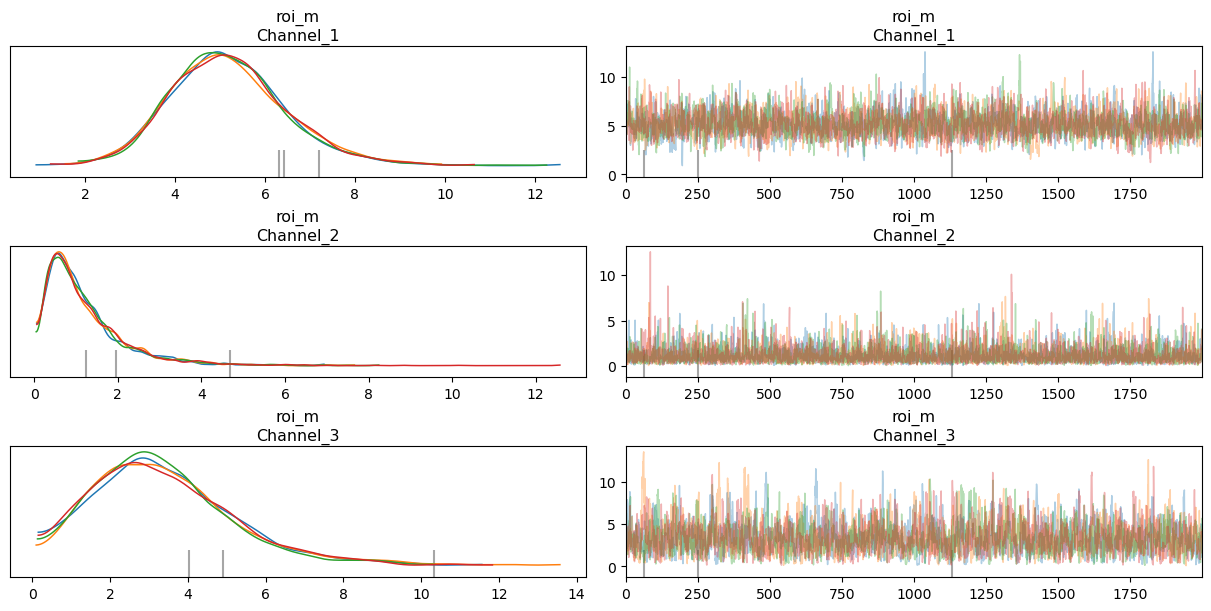

In [12]:
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )

In [13]:
model_diagnostics.plot_prior_and_posterior_distribution()

C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.FacetChart(...)

In [14]:
model_fit.plot_model_fit()

C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [15]:
model_diagnostics.predictive_accuracy_table()

C:\Users\usuari\anaconda3\Lib\site-packages\meridian\analysis\analyzer.py:188: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


metric geo_granularity evaluation_set     value
0   R_Squared        national          Train  0.797440
1   R_Squared        national           Test  0.220828
2   R_Squared        national       All Data  0.792993
3        MAPE        national          Train  0.131940
4        MAPE        national           Test  0.111008
5        MAPE        national       All Data  0.126632
6       wMAPE        national          Train  0.106839
7       wMAPE        national           Test  0.113251
8       wMAPE        national       All Data  0.108913
9       NRMSE        national          Train  0.137697
10      NRMSE        national           Test  0.136001
11      NRMSE        national       All Data  0.138777

In [16]:
media_summary = visualizer.MediaSummary(mmm)
media_summary.update_summary_metrics(confidence_level=0.95)

summary_df = media_summary.summary_table()
summary_df[summary_df["distribution"] == "posterior"]

C:\Users\usuari\anaconda3\Lib\site-packages\meridian\analysis\analyzer.py:539: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  warnings.warn(
C:\Users\usuari\anaconda3\Lib\site-packages\tensorflow\python\autograph\impl\api.py:371: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  return py_builtins.overload_of(f)(*args)
C:\Users\usuari\anaconda3\Lib\site-packages\meridian\analysis\visualizer.py:1553: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .aggregate(lambda g: f'{g[0]} ({g[1]}, {g[2]})')


channel distribution impressions % impressions     spend % spend  \
1     Channel_1    posterior     179,078           39%  $179,078     39%   
3     Channel_2    posterior     113,446           25%  $113,446     25%   
5     Channel_3    posterior     166,929           36%  $166,929     36%   
7  All Channels    posterior     459,452          100%  $459,452    100%   

      cpm                incremental outcome        % contribution  \
1  $1,000    $927,658 ($516,004, $1,438,652)   13.7% (7.6%, 21.3%)   
3  $1,000       $136,334 ($20,340, $427,317)     2.0% (0.3%, 6.3%)   
5  $1,000     $564,247 ($93,111, $1,314,508)    8.4% (1.4%, 19.5%)   
7  $1,000  $1,628,242 ($954,915, $2,515,714)  24.1% (14.1%, 37.2%)   

              roi      effectiveness            mroi               cpik  
1  5.2 (2.9, 8.0)  5.18 (2.88, 8.03)  3.1 (1.6, 4.9)  $0.2 ($0.1, $0.3)  
3  1.2 (0.2, 3.8)  1.20 (0.18, 3.77)  0.5 (0.1, 1.7)  $1.1 ($0.3, $5.6)  
5  3.4 (0.6, 7.9)  3.38 (0.56, 7.87)  1.6 (0.2, 3.4)  $0.3 ($0.1, $1.8)  
7  3.5 (2.1, 5.5)     nan (nan, nan)  nan (nan, nan)  $0.3 ($0.2, $0.5)

In [17]:
media_summary.plot_contribution_waterfall_chart()

C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [18]:
media_summary.plot_contribution_pie_chart()

C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [19]:
media_summary.plot_spend_vs_contribution()

C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.FacetChart(...)

In [20]:
media_summary.plot_roi_bar_chart()

C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [21]:
media_summary.plot_cpik()

C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [22]:
media_summary.plot_roi_vs_effectiveness()

C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [23]:
media_effects = visualizer.MediaEffects(mmm)
media_effects.plot_response_curves()

C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.FacetChart(...)

In [24]:
media_effects.plot_adstock_decay()

C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.FacetChart(...)

In [25]:
media_effects.plot_hill_curves()

C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\usuari\anaconda3\Lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.FacetChart(...)

For a customized two-page report, model results summary table, and individual visualizations, see [Model results report](https://developers.google.com/meridian/docs/user-guide/generate-model-results-report) and [plot media visualizations](https://developers.google.com/meridian/docs/user-guide/plot-media-visualizations).



